# SYSID - Atividade 05

Aluno: Pedro Henrique Cardoso Paulo<br>

Professor: Helon

## Objetivo

Nessa atividade vamos tentar aplicar os fundamentos da identificação contínua de sistemas. Devido a problemas com o Octave essa atividade será feita em Python, fazzendo uso das bibliotecas `scikitt-learn`, `control`, `scipy` e `numpy`

## Arquivos de suporte

Na pasta deste notebook poderão ser encontrados dois arquivos com funções e classes de suporte:

* <a href="./time_processing.py">time_processing.py</a>: pacote com função para reamostragem do sinal no tempo fazendo uso de interpolação
* <a href="./ContinuousDerivativePreprocessor.py">ContinuousDerivativePreprocessor.py</a>: tentativa de implementar, com a sitaxe sklearn um preprocessador de derivadas temporais

## Passo 0 - Importando bibliotecas

In [1]:
#Desabilitando warnings
#def warn(*args, **kwargs):
#    pass
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
#warnings.warn = warn

# Pacotes padrao
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
import datetime

# Pacotes customizados
from time_processing import *
from ContinuousDerivativePreprocessor import CDProcessor

# Compatibilidade matlab
import control.matlab as mtlb

#Pipeline
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV

#Definindo random_state
rs = 85

## Passo 0 - Importando os dados

### 0.1 - Lendo dados

In [2]:
data = np.genfromtxt('../data/measured_data.csv')
t = data[:,0]
y = data[:,5]
X = data[:,2]

### 0.2 - Visualizando dados

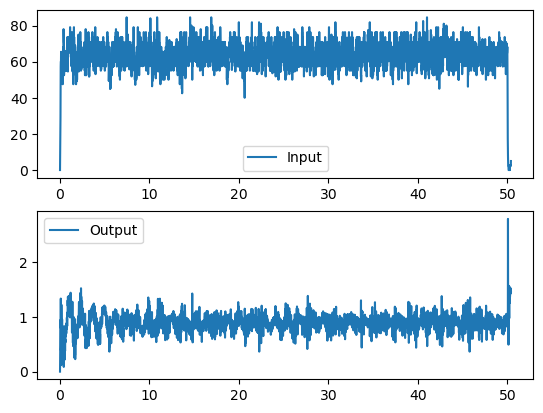

In [3]:
fig, ax = plt.subplots(2,1)
ax[0].plot(t, X, label='Input')
ax[1].plot(t, y, label='Output')
ax[0].legend()
ax[1].legend()

## Passo 1 - Aplicando a reamostragem

A reamostragem seré feita de modo a garantirmos um passo de tempo constante entre as amostras.

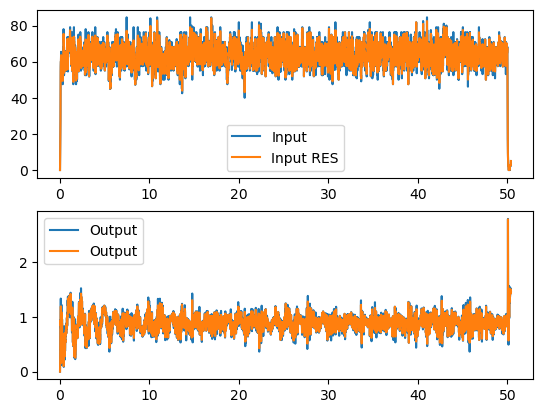

In [4]:
t_out, X_out, y_out = interpolation_resample(t, X, y, frequency=100)

fig, ax = plt.subplots(2,1)
ax[0].plot(t, X, label='Input')
ax[1].plot(t, y, label='Output')
ax[0].plot(t_out, X_out, label='Input RES')
ax[1].plot(t_out, y_out, label='Output')
ax[0].legend()
ax[1].legend()

## Passo 2 - Definindo a derivação do sinal de entrada

Para esse exemplo, ainda focaremos em um exemplo básico, sem uso das ferramentas de RandomizedSearch do Scikit-Learn. Para a estimativa de derivadas, vamos usar o pacote `control.matlab` para plicar uma função de transferência ao sinal que temos no momento. Dessa forma, para a estimativa da i-ésima derivada de um total de n derivadas de dada função no domínio de Laplace, podemos usar a seguinte função de transferência:

\begin{equation}
G_i(s) = \frac{\lambda^ns^i}{(s + \lambda)^n}
\end{equation}

Nessa função, o denominador representa um filtro passa baixa para uma frequência $\lambda$.

### 2.1 - Estudando a frequência de corte

In [5]:
s = mtlb.tf('s')
order = 5
frequency_vals = [0.1,1,2,3]

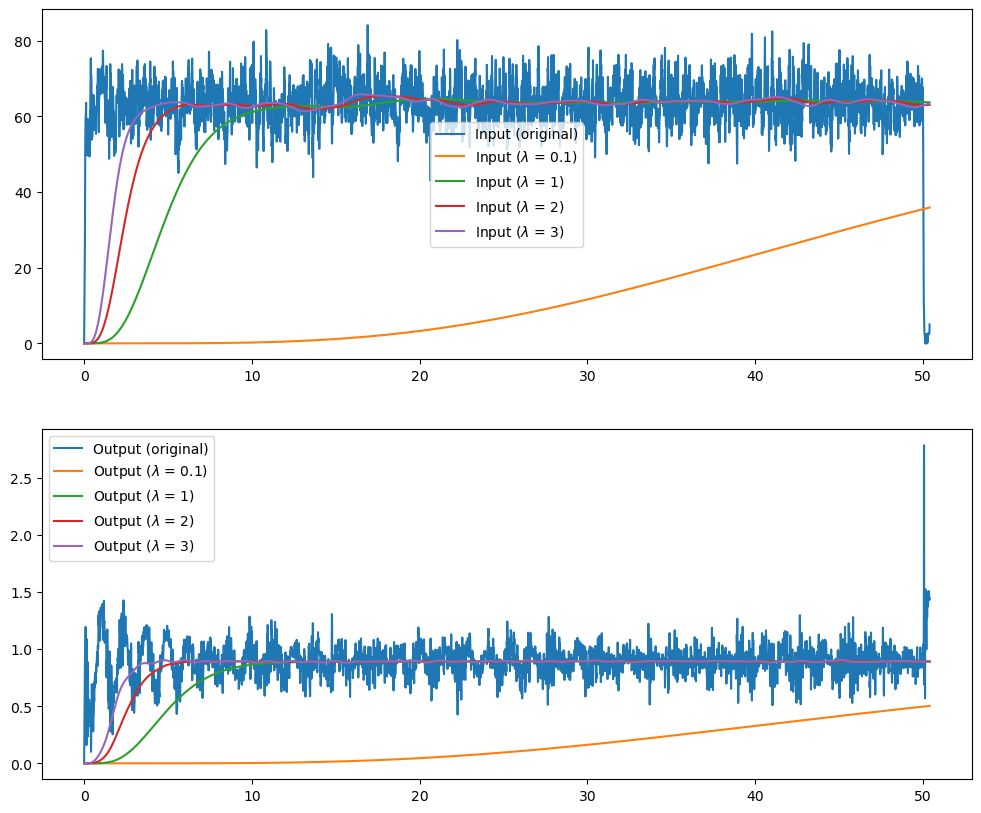

In [6]:
fig, ax = plt.subplots(2,1, figsize=(12, 10))
ax[0].plot(t_out, X_out, label='Input (original)')
ax[1].plot(t_out, y_out, label='Output (original)')

for frequency in frequency_vals:
    G = (frequency**order) * (1 / (s + frequency)**order)
    Xfilt, tfilt, _ = mtlb.lsim(G, X_out, t_out)
    yfilt, tfilt, _ = mtlb.lsim(G, y_out, t_out)

    ax[0].plot(tfilt, Xfilt, label=f'Input ($\lambda$ = {frequency})')
    ax[1].plot(tfilt, yfilt, label=f'Output ($\lambda$ = {frequency})')

ax[0].legend()
ax[1].legend()

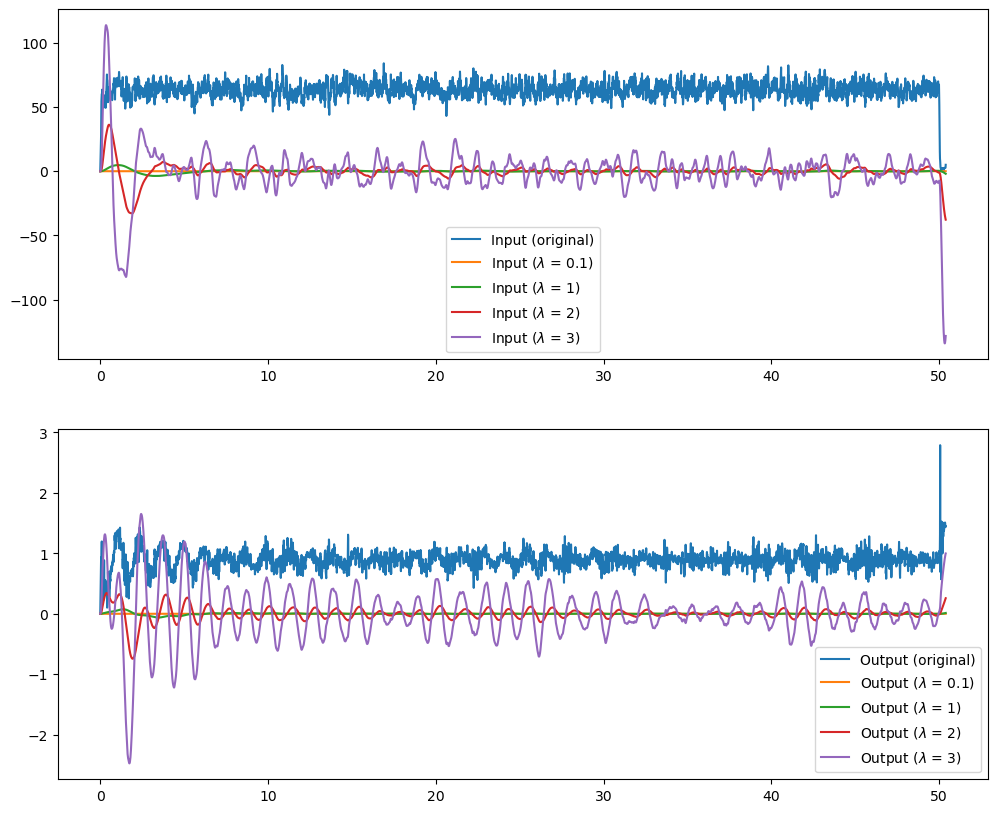

In [7]:
fig, ax = plt.subplots(2,1, figsize=(12, 10))
ax[0].plot(t_out, X_out, label='Input (original)')
ax[1].plot(t_out, y_out, label='Output (original)')

for frequency in frequency_vals:
    G = (frequency**order) * (s**3 / (s + frequency)**order)
    Xfilt, tfilt, _ = mtlb.lsim(G, X_out, t_out)
    yfilt, tfilt, _ = mtlb.lsim(G, y_out, t_out)

    ax[0].plot(tfilt, Xfilt, label=f'Input ($\lambda$ = {frequency})')
    ax[1].plot(tfilt, yfilt, label=f'Output ($\lambda$ = {frequency})')

ax[0].legend()
ax[1].legend()

## Passo 3 - Montando matriz de entrada e separando treino e teste

In [8]:
p_train = 0.7

In [9]:
X1 = np.hstack([
    np.array(t_out).reshape(-1,1), 
    X_out.reshape(-1,1), 
    y_out.reshape(-1,1),
    ])

n_train = int(X1.shape[0]*p_train)
X1_tr = X1[:n_train,:]
y_tr = y_out[:n_train]
t_tr = t_out[:n_train]
X1_te = X1[n_train:,:]
y_te = y_out[n_train:]
t_te = t_out[n_train:]

In [10]:
def declara_Pipeline(tupla_metodo):
    
    steps = [
        ('PreProcessor', CDProcessor(output_cols=[1])),
        tupla_metodo,
    ]
    return Pipeline(steps)

## Passo 4 - Listando os modelos a serem testados e definindo hiperparâmetros a tunar

Nessa etapa, vamos criar a lista dos modelos que queremos testar.

### 4.1 - Lista de modelos testados

In [20]:
models = [
    ('LinReg', LinearRegression(fit_intercept=False)),
]
n_models = len(models)


### 4.2 - Lista de parâmetros

A lista é em grande parte inspirada nos testes que fizemos na Atividade 03. Algumas variáveis que não tinha sensibilidade (como gamme e epsilon dos kernels do SVM) usei os valores do material de aula.

In [19]:
parameters = [
    {
        'PreProcessor__order_X'          : stats.randint(1,10),
        'PreProcessor__order_y'          : stats.randint(1,10),
        'PreProcessor__frequency_cut'    : stats.loguniform(1.0, 15.0),
    },
    
]

### 4.3 - Configurando KFolds

In [13]:

tmax = t_tr[-1]
nfolds = 3
rkf = [
    ((t_tr <= tmax/3),(tmax/3 < t_tr)&(t_tr <= 2*tmax/3),),
    ((tmax/3 < t_tr)&(t_tr <= 2*tmax/3),(2*tmax/3 < t_tr),),
]

## Passo 5 - Executando os modelos

Nossa comparação será realizada a partir de um loop padrão no qual extrairemos os seguintes valores:

* Tempo de execução do RandomSearchCV
* Melhores valores dos parâmetros
* Acurácia dos modelos nos conjuntos de treino e teste
* Matriz de confusão para cada caso

Iniciando avaliação do modelo: LinReg


/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/control/timeresp.py:935: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/control/timeresp.py:935: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/control/timeresp.py:935: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/control/timeresp.py:935: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
/home/pedro-linux/miniconda3

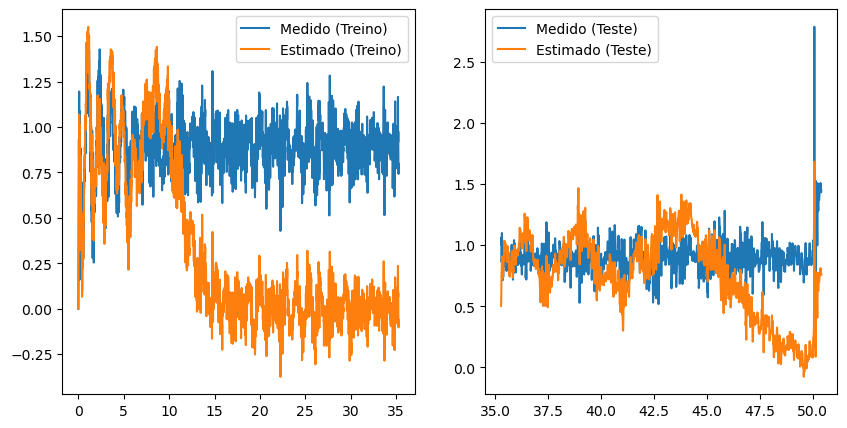

In [21]:
n_iter = 100 #Numero de iterações do rdmsearch 

fig, axs = plt.subplots(ncols=2, nrows=n_models, figsize=(10,n_models*5))

if n_models <= 1: axs = axs.reshape(1,-1)
#Loop principal, iterando sobre as listas
for i in range(n_models):
    
    model = models[i]
    params = parameters[i]
    #print(params)
    model_name = model[0]
    print('Iniciando avaliação do modelo: {}'.format(model_name))
    
    #Primeira etapa - criacao do Pipeline
    pipeline = declara_Pipeline(model)
    
    t0 = datetime.datetime.now()
    
    #rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
    
        rdmsearch = RandomizedSearchCV(pipeline, verbose=0, scoring='r2', 
                                        param_distributions=params, n_iter=n_iter, n_jobs=6, 
                                        cv=rkf, random_state=rs)
    
        rdmsearch.fit(X1_tr, y_tr)

    axs[i,0].plot(t_tr, y_tr, label='Medido (Treino)')
    axs[i,0].plot(t_tr, rdmsearch.predict(X1_tr), label='Estimado (Treino)')
    axs[i,0].legend()

    axs[i,1].plot(t_te, y_te, label='Medido (Teste)')
    axs[i,1].plot(t_te, rdmsearch.predict(X1_te), label='Estimado (Teste)')
    axs[i,1].legend()
    


In [22]:
best_pars = rdmsearch.best_params_
for best_par in best_pars.keys():
    print(best_par,':',best_pars[best_par])

PreProcessor__frequency_cut : 1.240636580627055
PreProcessor__order_X : 1
PreProcessor__order_y : 8


In [26]:
param_linreg = rdmsearch.best_estimator_.named_steps['LinReg'].coef_
num = [p for p in param_linreg[:best_pars['PreProcessor__order_X']+1]]
den = [1] + [p for p in param_linreg[best_pars['PreProcessor__order_X']+1:]]
print(param_linreg)
print(num[::-1], den[::-1])

[0.00000000e+00 1.52703767e-03 1.28733101e+01 2.11993058e+00
 5.74118286e+01 8.23830823e+00 3.50552746e+01 4.11879296e+00
 2.60095877e+00 1.27738678e-01]
[0.0015270376686864651, 0.0] [0.12773867752980916, 2.6009587681713064, 4.1187929616391115, 35.05527456496107, 8.23830823342732, 57.41182860096874, 2.1199305789408887, 12.873310076114398, 1]


In [24]:
print('Score obtido para o grupo de treino (R2): {}'.format(rdmsearch.score(X1_tr, y_tr)))
print('Score obtido para o grupo de teste (R2):  {}'.format(rdmsearch.score(X1_te, y_te)))

Score obtido para o grupo de treino (R2): -23.05925276148202
Score obtido para o grupo de teste (R2):  -5.872062000308938


In [27]:
G2 = mtlb.tf(num[::-1], den[::-1])
print(G2)


                                          0.001527 s
-----------------------------------------------------------------------------------------------
0.1277 s^8 + 2.601 s^7 + 4.119 s^6 + 35.06 s^5 + 8.238 s^4 + 57.41 s^3 + 2.12 s^2 + 12.87 s + 1



In [195]:
lmbd = best_pars['PreProcessor__frequency_cut']
G3 = lmbd**2/(s + lmbd)**2
print(G3)


        1.419
---------------------
s^2 + 2.382 s + 1.419



In [28]:
y_tr_f = X1_tr[:,1]#mtlb.lsim(G3, X1_tr[:,1], t_tr)
y_te_f = X1_te[:,1]#mtlb.lsim(G3, X1_te[:,1], t_te)
y_tr_sim, t_tr_sim, _ = mtlb.lsim(G2, y_tr_f, t_tr)
y_te_sim, t_te_sim, _ = mtlb.lsim(G2, y_te_f, t_te)

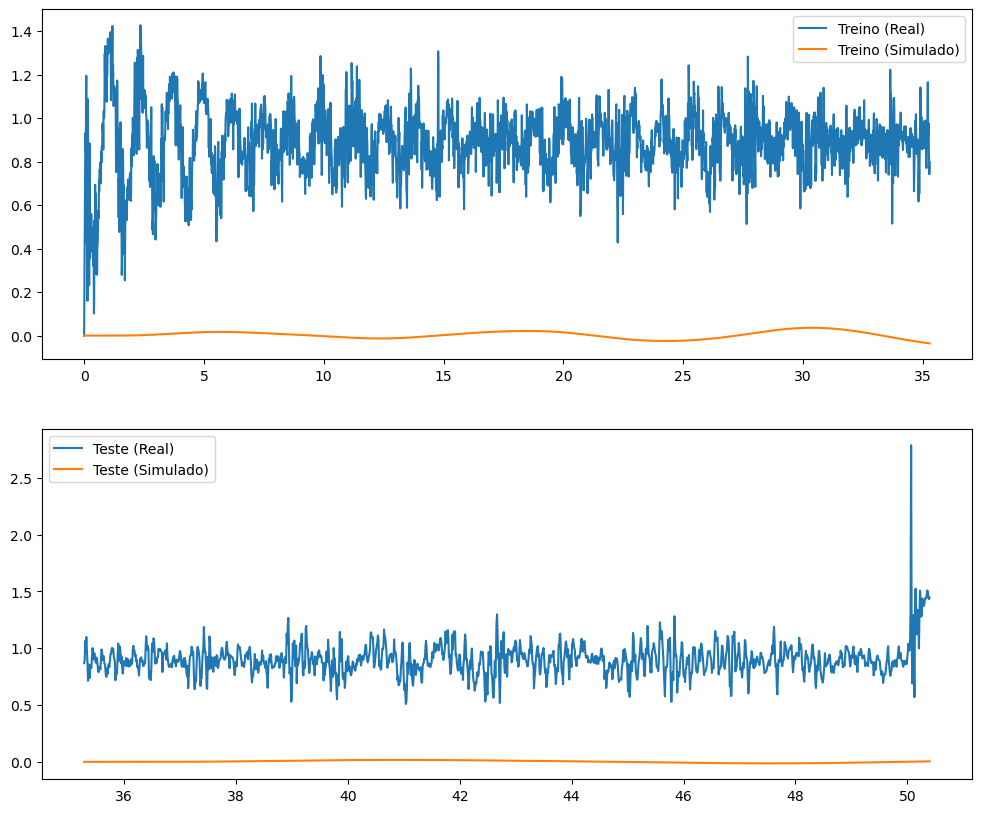

In [31]:
fig, ax = plt.subplots(2,1, figsize=(12,10))
ax[0].plot(t_tr, y_tr, label='Treino (Real)')
ax[1].plot(t_te, y_te, label='Teste (Real)')
ax[0].plot(t_tr_sim, y_tr_sim, label='Treino (Simulado)')
ax[1].plot(t_te_sim, y_te_sim, label='Teste (Simulado)')
ax[0].legend()
ax[1].legend()